<a href="https://colab.research.google.com/github/mobadata/detection-nouveautes-avis/blob/main/lda_detection_nouveautes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import nltk
nltk.download("punkt_tab")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("punkt")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
import re
import gc
from collections import Counter
from types import SimpleNamespace

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer as wnl
from nltk.tokenize import word_tokenize

## Configs

In [7]:
cfg = SimpleNamespace(**{})

In [8]:
cfg.data_path = "/content/drive/MyDrive/customers_feedbacks_trends/data/inputs/train_reviews.parquet"
cfg.lda_grid_params = {'n_components': [5, 10, 15, 20], 'learning_decay': [.1, .3, .5, .7]}
cfg.seed = 57
cfg.stop_words = set(stopwords.words('english'))
cfg.vect_params = {"ngram_range": (1, 3), "min_df": 0., "max_df": 0.9}

## Import data

In [9]:
reviews_df = pd.read_parquet(cfg.data_path)

In [10]:
reviews_df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,year
1,AMO214LNFCEI4,0528881469,Amazon Customer,"[12, 15]","I'm a professional OTR truck driver, and I bou...",1,Very Disappointed,1290643200,2010-11-25,2010
2,A3N7T0DY83Y4IG,0528881469,C. A. Freeman,"[43, 45]","Well, what can I say. I've had this unit in m...",3,1st impression,1283990400,2010-09-09,2010
3,A1H8PY3QHMQQA0,0528881469,"Dave M. Shaw ""mack dave""","[9, 10]","Not going to write a long review, even thought...",2,"Great grafics, POOR GPS",1290556800,2010-11-24,2010
4,A24EV6RXELQZ63,0528881469,Wayne Smith,"[0, 0]",I've had mine for a year and here's what we go...,1,"Major issues, only excuses for support",1317254400,2011-09-29,2011
20,A1EDI0X3GI1SK7,0972683275,AGW,"[0, 1]","Great deal, easy to mount and it appears to be...",5,32 In TV Mount,1323993600,2011-12-16,2011


In [11]:
reviews_df["reviewTime"] = pd.to_datetime(reviews_df["reviewTime"])
reviews_df['year'] = reviews_df["reviewTime"].dt.year

In [12]:
reviews_per_year = reviews_df['year'].value_counts().sort_index()

In [13]:
reviews_per_year_cum_sum = reviews_per_year.cumsum() / reviews_per_year.sum()

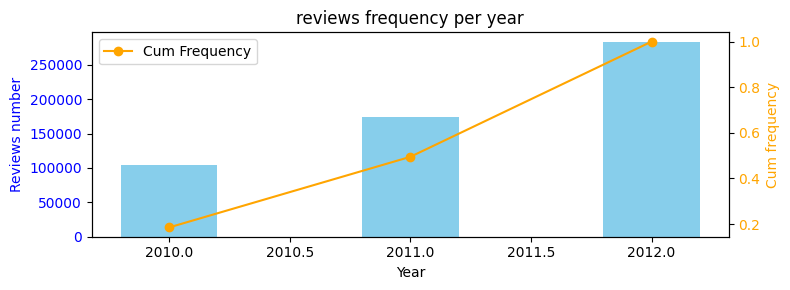

In [14]:
fig, ax1 = plt.subplots(figsize=(8, 3))

# Graphique des fréquences des avis (axe principal)
ax1.bar(reviews_per_year.index, reviews_per_year, width=0.4, label='Reviews number', color='skyblue', align='center')
ax2 = ax1.twinx()
ax2.plot(reviews_per_year_cum_sum.index, reviews_per_year_cum_sum, label='Cum Frequency', color='orange', marker='o')

ax1.set_title('reviews frequency per year')
ax1.set_xlabel('Year')
ax1.set_ylabel("Reviews number", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2.set_ylabel('Cum frequency', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')


fig.tight_layout()
plt.legend(loc='upper left')
plt.show()

# Train test split

The data coverage is from 1999. But as we are interested to detect new topics in the as they arrive, it's seems not relevant for us to analyse the data on the full coverage. Customers consumption behavior evolve in time and on such large window the criteria to evaluate the product will probably change a lot. Also the computing resources we have at end make constraints our choise to limit the area of our study. So we will split the dataset in 3: [1999; 2010) removed, [2010- 2013] test set and [2013; 2014].

In [15]:
train_df = reviews_df[(reviews_df["year"] > 2009) & (reviews_df["year"] < 2013)]

In [16]:
del reviews_df, reviews_per_year, reviews_per_year_cum_sum
gc.collect()

18

## preprocessing

In [17]:
def nettoyer_texte(texte, stop_words):
  """low all documents, remove special chars, tokenize and lemmatize them then remove stopwords """
  lemmatizer = wnl()
  if isinstance(texte, str):
    texte = texte.lower()
    texte = re.sub(r"[^a-z\s]", "", texte)
    tokens = word_tokenize(texte)
    lemma = [lemmatizer.lemmatize(word=token) for token in tokens]
    mots_utiles = [mot for mot in lemma if mot not in stop_words]
    return " ".join(mots_utiles)
  else:
        return ""

In [18]:
train_df["review_clean"] = train_df["reviewText"].apply(lambda review: nettoyer_texte(review, cfg.stop_words))

In [ ]:
count_vectorizer = CountVectorizer(**cfg.vect_params)
text_counts = count_vectorizer.fit_transform(train_df["review_clean"])
count_df = pd.DataFrame(text_counts.toarray(), columns = count_vectorizer.get_feature_names())

In [ ]:
lda = LatentDirichletAllocation(n_components=10,
                                n_jobs=-1,
                                random_state=cfg.seed,
                                verbose=1)

In [ ]:
clf = GridSearchCV(estimator=lda,
                   param_grid=cfg.lda_grid_params,
                   error_score='raise',
                   cv=5,
                   n_jobs=-1,
                   refit=True)